In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import sys
sys.path.append('..')

from helpers import utils, pipelines, models

from sklearn.model_selection import train_test_split
import resreg

import dice_ml

import multiprocessing

from collections.abc import Iterable
from functools import partial

from copy import deepcopy

### Define research parameters

In [3]:
scoring = 'neg_root_mean_squared_error'#neg_root_mean_squared_log_error#r2

test_size_proportion=0.2

augmentation_proportion = 0.5

search_pipelines = pipelines.get_regression_pipelines()
search_parameters = models.regression_parameters

### Read and preprocess data

In [4]:
df = pd.read_csv(r'../datasets/diabetes.txt', sep='\t')
target = 'Y'

#### split data

In [5]:
# all data
X = df.drop(target, axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size_proportion, random_state=42)
df_train = pd.concat([X_train, y_train], axis=1)

### without augmentation scores

without augmentation neg_root_mean_squared_error scores:


,lr,ridge,lasso,rf,xgb
w/o aug neg_root_mean_squared_error score,53.853446,53.842869,53.774196,53.762652,53.92463


<AxesSubplot:>

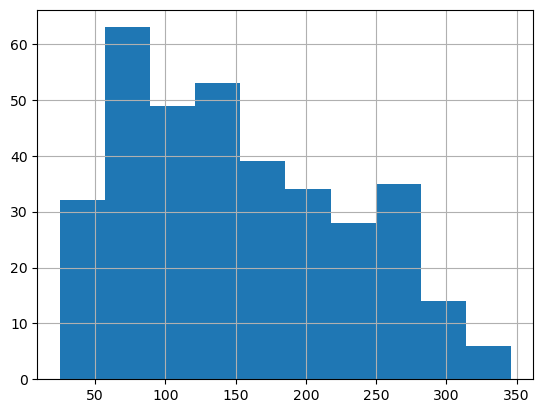

In [6]:
print(f'without augmentation {scoring} scores:')
whole_best_ests, whole_scores = utils.fit_and_evaluate(X_train, y_train, X_test, y_test,
                    search_estimators=search_pipelines, search_params=search_parameters, scoring=scoring)
whole_dataset_result_df = pd.DataFrame.from_dict(whole_scores, orient='index', columns=[f'w/o aug {scoring} score'])
display(whole_dataset_result_df.T)
y_train.hist()

### Random over sampling 

(353, 10)
(529, 10)
50.0% aug dataset with Random Over Sampling neg_root_mean_squared_error scores:


,lr,ridge,lasso,rf,xgb
ROS neg_root_mean_squared_error score,54.329898,54.305594,54.266014,52.980496,63.883239


<AxesSubplot:>

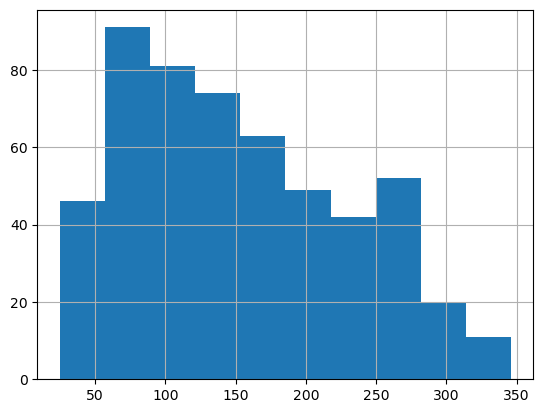

In [7]:
print(X_train.shape)

df_train_ros = pd.concat([df_train, df_train.sample(frac=augmentation_proportion, random_state=42)])
X_train_ros = df_train_ros.drop(target, axis=1)
y_train_ros = df_train_ros[target]

print(X_train_ros.shape)


print(f'{augmentation_proportion*100}% aug dataset with Random Over Sampling {scoring} scores:')
ros_best_ests, sampled_scores = utils.fit_and_evaluate(X_train_ros, y_train_ros, X_test, y_test,
                        search_estimators=search_pipelines, search_params=search_parameters, scoring=scoring)
ros_result_df = pd.DataFrame.from_dict(sampled_scores, orient='index', columns=[f'ROS {scoring} score'])
display(ros_result_df.T)
display(y_train_ros.hist())

### random resmapling for balancing

(394, 10)
50.0% aug dataset with balancing Random Over Sampling neg_root_mean_squared_error scores:


,lr,ridge,lasso,rf,xgb
RES neg_root_mean_squared_error score,54.407337,54.39879,54.308541,53.811878,54.198043


<AxesSubplot:>

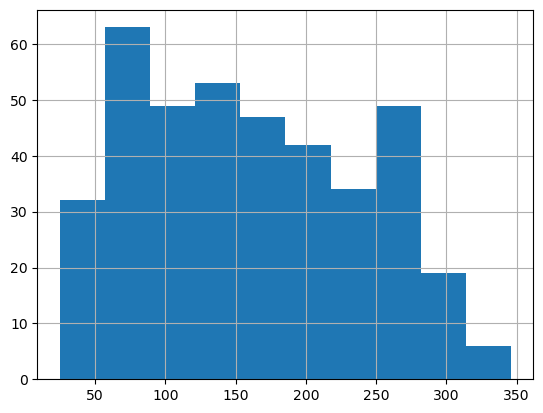

In [8]:
# Resample training set with random oversampling such that values above and below mean are equal size
# relevance = resreg.sigmoid_relevance(y_train, cl=None, ch=np.percentile(y, 50))
y_train_mean = y_train.mean()
relevance = [1 if y>y_train_mean else 0 for y in y_train]
X_train_res, y_train_res = resreg.random_oversample(X_train, y_train, relevance,
                                                      relevance_threshold=0.5,
                                                      over='balance', random_state=42)

X_train_res = pd.DataFrame(X_train_res, columns=X_train.columns).astype(X_train.dtypes)
y_train_res = pd.Series(y_train_res, name=target)

print(X_train_res.shape)

print(f'{augmentation_proportion*100}% aug dataset with balancing Random Over Sampling {scoring} scores:')
_, sampled_scores = utils.fit_and_evaluate(X_train_res, y_train_res, X_test, y_test,
                        search_estimators=search_pipelines, search_params=search_parameters, scoring=scoring)
res_result_df = pd.DataFrame.from_dict(sampled_scores, orient='index', columns=[f'RES {scoring} score'])
display(res_result_df.T)
y_train_res.hist()

### SMOTE 
in this implementation the rare domain is oversampled and the normal domain is undersampled so that they are equal in size.

(352, 10)
50.0% aug dataset with balancing smoter neg_root_mean_squared_error scores:


,lr,ridge,lasso,rf,xgb
SMOTER neg_root_mean_squared_error score,54.407337,54.39879,54.308541,53.811878,54.198043


<AxesSubplot:>

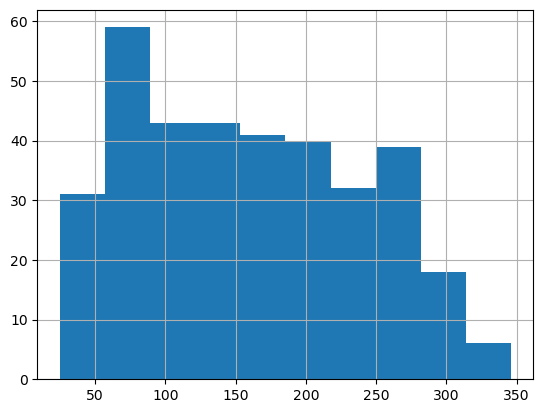

In [9]:
# Resample training such that values above and below mean are equal size
y_train_mean = y_train.mean()
relevance = [1 if y>y_train_mean else 0 for y in y_train]
X_train_smoter, y_train_smoter = resreg.smoter(X_train, y_train, relevance,
                                                      relevance_threshold=0.5,
                                                      nominal=['SEX'],
                                                      over='balance', random_state=42)

X_train_smoter = pd.DataFrame(X_train_smoter, columns=X_train.columns).astype(X_train.dtypes)
y_train_smoter = pd.Series(y_train_smoter, name=target)

print(X_train_smoter.shape)

print(f'{augmentation_proportion*100}% aug dataset with balancing smoter {scoring} scores:')
_, sampled_scores = utils.fit_and_evaluate(X_train_res, y_train_res, X_test, y_test,
                        search_estimators=search_pipelines, search_params=search_parameters, scoring=scoring)
smoter_result_df = pd.DataFrame.from_dict(sampled_scores, orient='index', columns=[f'SMOTER {scoring} score'])
display(smoter_result_df.T)
y_train_smoter.hist()

### Counter Factuals

for now we want to flip values over mean by maximum 1 std

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor

knn_pipeline = {'knn': Pipeline([('column_transformer', pipelines.preprocessor),('model', KNeighborsRegressor())])}
knn_params = {'knn': {'model__n_neighbors': list(range(1,21)), 'model__weights': ['uniform', 'distance'],
                      'model__p': [1,2], 'model__algorithm': ['ball_tree', 'kd_tree', 'brute']}}
best_knn_estimator, sampled_scores = utils.fit_and_evaluate(X_train, y_train, X_test, y_test,
                        search_estimators=knn_pipeline, search_params=knn_params, scoring=scoring)
pd.DataFrame.from_dict(sampled_scores, orient='index', columns=[f'sampled data {scoring} score']).T

,knn
sampled data neg_root_mean_squared_error score,54.068212


In [7]:
d = dice_ml.Data(dataframe=df, continuous_features=['AGE', 'BMI', 'BP', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6'], outcome_name=target)
m = dice_ml.Model(model=best_knn_estimator['knn'], backend="sklearn", model_type='regressor')

#### random

In [8]:
cf_method = 'random'
exp = dice_ml.Dice(d, m, method=cf_method) # need to check diferent method (random, genetic, kdtree)

num_of_samples = int(augmentation_proportion*len(X_train))
y_train_min = y_train.min()
y_train_max = y_train.max()
y_train_mean = y_train.mean()
y_train_std = y_train.std()
train_dtypes = X_train.dtypes

augmented_data = pd.DataFrame()
cf_per = 1
cf_counter = 0
for i, (index, row) in enumerate(X_train.iterrows()):
    if cf_counter >= num_of_samples: break
    if i%50 == 0: print(f'{i}/{num_of_samples}')
    try:
        if y_train[index] >= y_train_mean:
            # wanted_range = [y_train_mean-y_train_std, y_train_mean]
            upper_flip = min(y_train[index]-y_train_std, y_train_mean)
            lower_flip = max(y_train_min, upper_flip-y_train_std)
            wanted_range = [lower_flip, upper_flip]
        else:
            # wanted_range = [y_train_mean, y_train_mean+y_train_std]
            lower_flip = max(y_train[index]+y_train_std, y_train_mean)
            upper_flip = min(y_train_max, lower_flip+y_train_std)
            wanted_range = [lower_flip, upper_flip]
        e1 = exp.generate_counterfactuals(pd.DataFrame(row).T.astype(train_dtypes), total_CFs=cf_per, desired_range=wanted_range, random_seed=42)
                                        #   proximity_weight=1, diversity_weight=0)#, verbose=False)
        cf_df = e1.cf_examples_list[0].final_cfs_df
        augmented_data = pd.concat([augmented_data, cf_df])
        cf_counter += len(cf_df)
    except:
        pass


X_augmented_cf = pd.concat([X_train, augmented_data.drop(target, axis=1)]).astype(X_train.dtypes)
y_augmented_cf = pd.concat([y_train, augmented_data[target]])

print(f'{augmentation_proportion*100}% aug dataset with {cf_method} CF {scoring} scores:')
best_est_cf_random, sampled_scores = utils.fit_and_evaluate(X_augmented_cf, y_augmented_cf, X_test, y_test,
                        search_estimators=search_pipelines, search_params=search_parameters, scoring=scoring)
random_cf_result_df = pd.DataFrame.from_dict(sampled_scores, orient='index', columns=[f'CF {scoring} score'])
display(random_cf_result_df.T)
y_augmented_cf.hist()

0/176


  0%|          | 0/1 [00:00<?, ?it/s]

# summary

In [15]:
result_df = pd.concat([whole_dataset_result_df, ros_result_df, res_result_df, smoter_result_df, random_cf_result_df], axis=1)
result_df

,w/o aug neg_root_mean_squared_error score,ROS neg_root_mean_squared_error score,RES neg_root_mean_squared_error score,SMOTER neg_root_mean_squared_error score,CF neg_root_mean_squared_error score,CF2 neg_root_mean_squared_error score,CF3 neg_root_mean_squared_error score
lr,53.853446,54.329898,54.407337,54.407337,54.007225,54.007225,54.007225
ridge,53.842869,54.305594,54.398790,54.398790,54.001259,54.001259,54.001259
lasso,53.774196,54.266014,54.308541,54.308541,53.437771,53.437771,53.437771
rf,53.762652,52.980496,53.811878,53.811878,53.652894,53.652894,53.652894
xgb,53.924630,63.883239,54.198043,54.198043,51.442673,51.442673,51.442673


In [16]:
result_df.to_csv(rf'log/diabetes_{scoring}_{str(int(augmentation_proportion*100))}%.csv') 